# 20기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric, NearestNeighbors
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder


In [19]:
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocssing / EDA

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [21]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

In [22]:
for i in df.columns:
    print(i,':',df[i].nunique())

User_ID : 2656
Product_ID : 1797
Gender : 2
Age : 7
Occupation : 21
City_Category : 3
Stay_In_Current_City_Years : 5
Marital_Status : 2
Product_Category_1 : 20
Product_Category_2 : 17
Product_Category_3 : 15
Purchase : 3736


결측치가 존재하는 'Product_Category_2', 'Product_Category_3'에 대해 결측치를 대체한다. nunique가 크게 나타나는 경우를 파악한다. 
- 'Product_Category_2'의 경우 분포에서 특이점을 찾을 수 없고, 평균 부근에서 많은 빈도수가 관찰되는 것 또한 아니므로 column을 drop처리한다.
- 'Product_Category_3'의 경우 16에서 빈도수가 확연하게 크게 나타나므로 16으로 대체한다.
- 'User_ID','Product_ID'은 식별을 위한 정보이므로 nunique가 크고, price 예측을 위한 상관관계가 없으리라 판단하여 drop처리한다.


Text(0.5, 0, 'Product_Category_3')

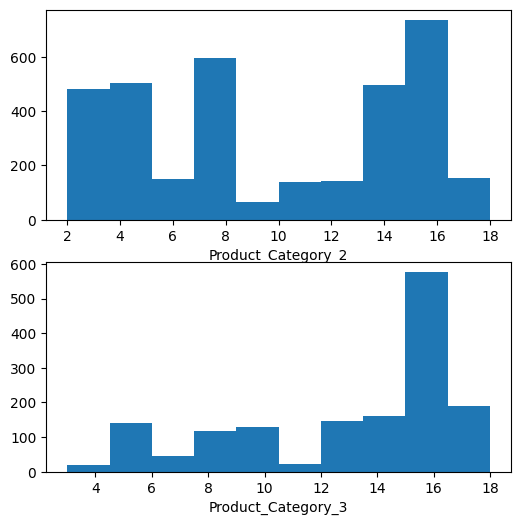

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

plt.subplot(211)
plt.hist(df['Product_Category_2'])
plt.xlabel('Product_Category_2')

plt.subplot(212)
plt.hist(df['Product_Category_3'])
plt.xlabel('Product_Category_3')


In [24]:
df['Product_Category_3'].mode()

0    16.0
Name: Product_Category_3, dtype: float64

In [25]:
df=df.drop(['User_ID','Product_ID','Product_Category_2'], axis=1)

In [26]:
df['Product_Category_3']=df['Product_Category_3'].fillna(16)

In [27]:
df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_3,Purchase
0,F,0-17,10,A,3,0,5,16.0,2010
1,F,0-17,10,A,1,0,7,16.0,4483
2,F,0-17,10,A,1,0,1,16.0,7696
3,F,0-17,10,A,3,0,2,16.0,16429
4,F,0-17,10,A,3,0,3,16.0,5780


In [28]:
df.columns

Index(['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_3', 'Purchase'],
      dtype='object')

## 2. KNN 구현 & 파라미터 튜닝

In [72]:
y=df.iloc[:,-1]
X=df.iloc[:,:-1]

In [73]:
categorical = ['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_3']

encoder = OneHotEncoder(sparse=False)
X=encoder.fit_transform(X[categorical])

C:\Users\mihye\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [77]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [75]:
print(X_train.shape)
print(X_test.shape)

(3998, 75)
(1000, 75)


### 파라미터 튜닝: minkowski distance

In [119]:
k_range = range(1,30)
train_accuracy_m = []
test_accuracy_m = []

for k in tqdm_notebook(k_range):
    knn = KNeighborsRegressor(n_neighbors = k,metric='minkowski')     # default : weights = 'uniform(가중치 없음)', p = 2 (standard Euclidean metric)
    knn.fit(X_train, y_train)
    train_accuracy_m.append(knn.score(X_train, y_train))     # Train Data에 대한 결정계수
    test_accuracy_m.append(knn.score(X_test, y_test))

C:\Users\mihye\AppData\Local\Temp\ipykernel_7384\1933806073.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_range):


  0%|          | 0/29 [00:00<?, ?it/s]

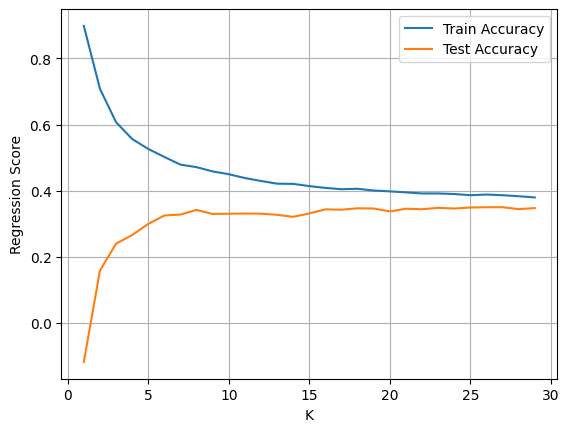

In [120]:
plt.plot(k_range, train_accuracy_m, label = "Train Accuracy")
plt.plot(k_range, test_accuracy_m, label = "Test Accuracy")
plt.xlabel("K")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

### 파라미터 튜닝: euclidean distance

In [121]:
k_range = range(1,30)
train_accuracy = []
test_accuracy = []

for k in tqdm_notebook(k_range):
    knn = KNeighborsRegressor(n_neighbors = k,metric = 'euclidean')     # default : weights = 'uniform(가중치 없음)', p = 2 (standard Euclidean metric)
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))     # Train Data에 대한 결정계수
    test_accuracy.append(knn.score(X_test, y_test))

C:\Users\mihye\AppData\Local\Temp\ipykernel_7384\1235411643.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_range):


  0%|          | 0/29 [00:00<?, ?it/s]

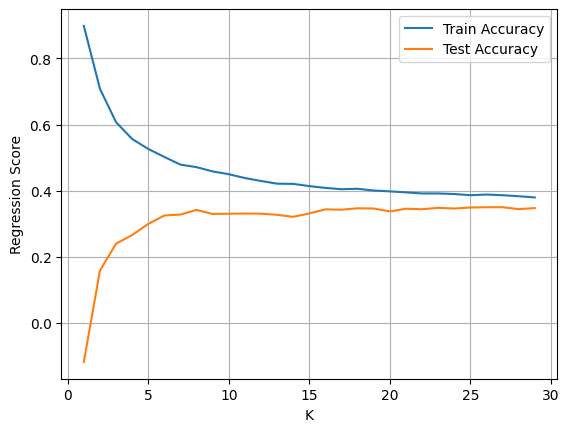

In [122]:
plt.plot(k_range, train_accuracy, label = "Train Accuracy")
plt.plot(k_range, test_accuracy, label = "Test Accuracy")
plt.xlabel("K")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

## 3. Evaluation

- minkowski distance

In [133]:
print('k=',test_accuracy_m.index(max(test_accuracy_m)),'에서 최대 accuracy', max(test_accuracy_m))

k_5=sorted(test_accuracy_m,reverse=True)[:5]
for i in k_5:
    print(test_accuracy_m.index(i),end=' ')
print('가 k의 후보가 된다.')

k= 26 에서 최대 accuracy 0.34974972124870096
26 25 24 22 28 가 k의 후보가 된다.


- euclidean distance

In [134]:
print('k=',test_accuracy.index(max(test_accuracy)),'에서 최대 accuracy', max(test_accuracy))

k_5=sorted(test_accuracy,reverse=True)[:5]
for i in k_5:
    print(test_accuracy.index(i),end=' ')
print('가 k의 후보가 된다.')

k= 26 에서 최대 accuracy 0.34974972124870096
26 25 24 22 28 가 k의 후보가 된다.
